In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import random
import matplotlib.image as mpimg
from tqdm import tqdm
from PIL import Image
from shutil import copyfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam

from keras.applications import DenseNet121
from keras.applications import ResNet50V2
from keras.applications import ResNet152V2
from keras.applications import InceptionV3
from keras.applications import Xception

2024-08-13 12:43:57.924827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 12:43:57.924967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 12:43:58.099197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Data Preprocessing

CAT_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'
DOG_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'

try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/validation')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/validation/cats')
    os.mkdir('/tmp/cats-v-dogs/validation/dogs')
except OSError:
    print('Error failed to make directory')

In [3]:
import plotly.express as px
class_names = ['Cat', 'Dog'] 

n_dogs = len(os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'))
n_cats = len(os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

In [4]:
def split_data(main_dir, training_dir, validation_dir, split_size):
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)):
            files.append(file) 

    shuffled_files = random.sample(files,  len(files))
    split = int(0.9 * len(shuffled_files))

    train = shuffled_files[:split]
    validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element))

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))

In [5]:
split_data(CAT_DIR, '/tmp/cats-v-dogs/training/cats','/tmp/cats-v-dogs/validation/cats', 0.9)
split_data(DOG_DIR, '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/validation/dogs', 0.9)

In [6]:
# Image augmentation and resizing

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory('/tmp/cats-v-dogs/training',
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))     


validation_generator =  valid_datagen.flow_from_directory( '/tmp/cats-v-dogs/validation',
                                                          batch_size  = 32,
                                                          class_mode  = 'binary', 
                                                          target_size = (224, 224))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [7]:
def plot_data(generator, n_images):
    i = 1
    images, labels = next(generator)
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i > n_images:
            break
    
    plt.show()

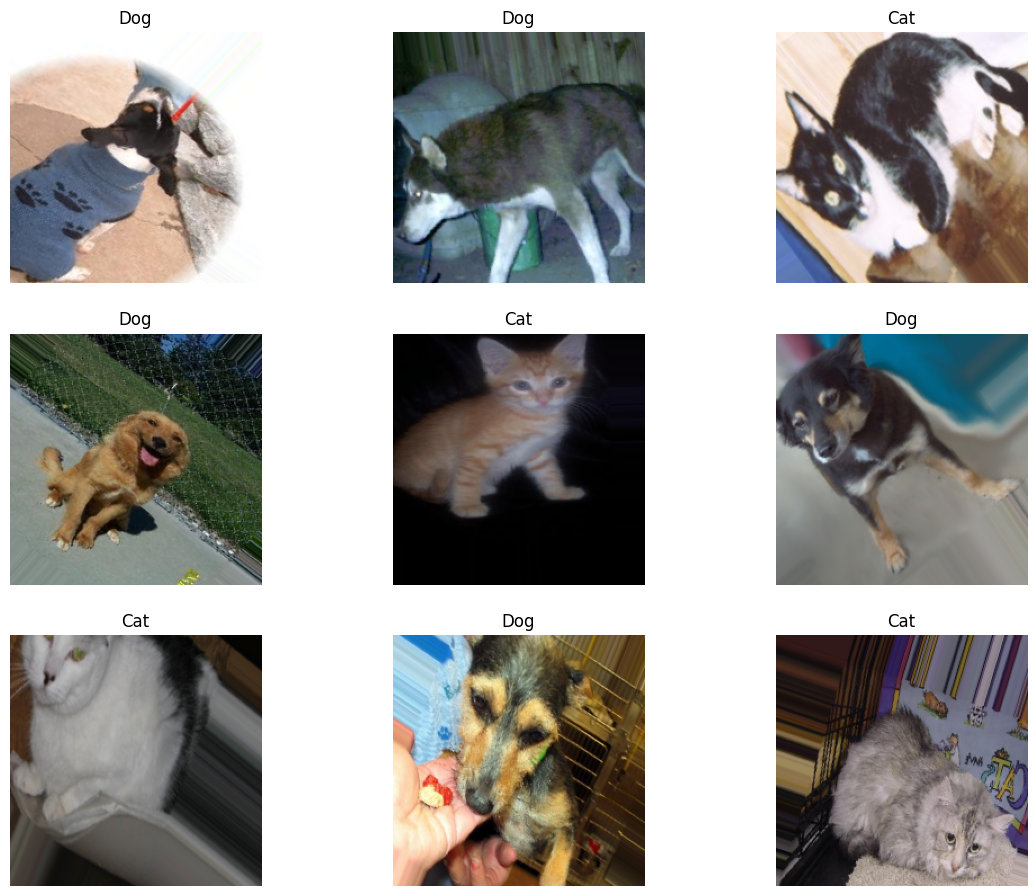

In [8]:
plot_data(train_generator,9)

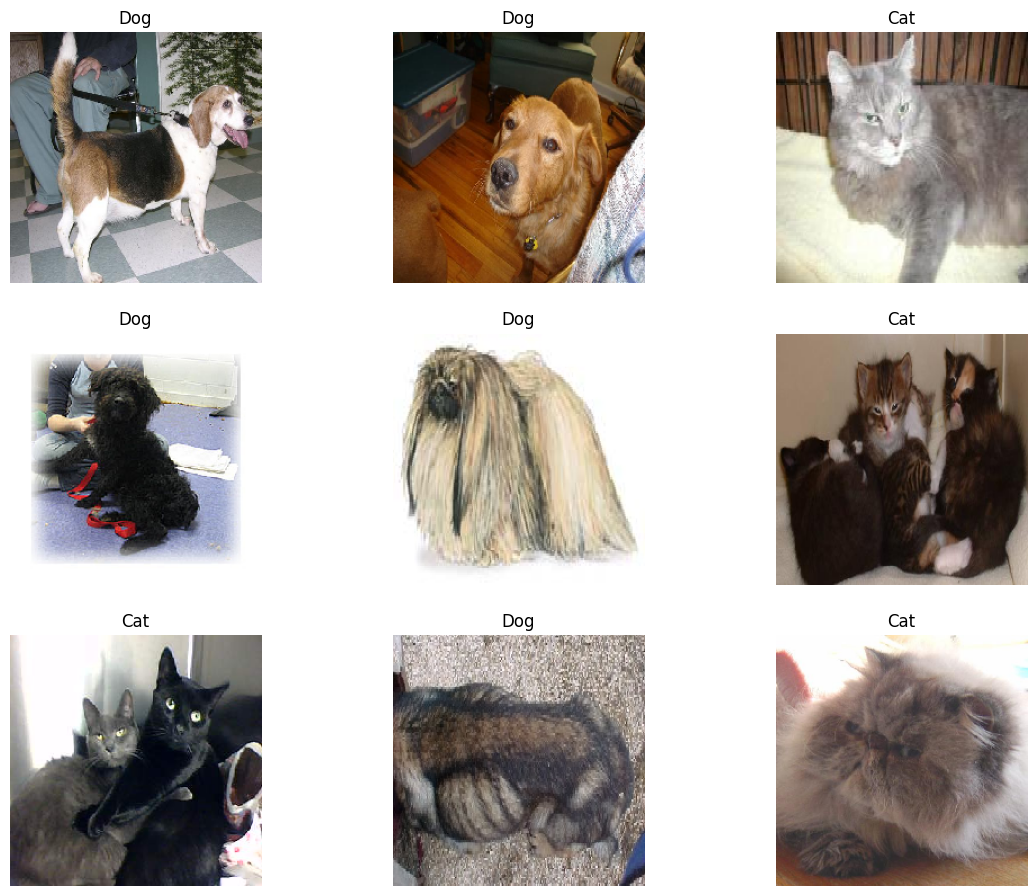

In [9]:
plot_data(validation_generator,9)

In [10]:
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [11]:
# Load inception v3 model

inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(224,224,3))

for layer in inception.layers[:-10]:
    layer.trainable=False

last_layer=inception.get_layer('mixed7')

print('Last layer output shape:',last_layer.output.shape)

layer_output = last_layer.output

x = Flatten()(layer_output)
x = BatchNormalization()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2,activation='softmax')(x)
model = Model(inception.input,predictions)

model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Last layer output shape: (None, 12, 12, 768)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 122,666,914 (467.94 MB)

 Trainable params: 113,470,466 (432.86 MB)

 Non-trainable params: 9,196,448 (35.08 MB)

In [12]:
def scheduler(epoch,lr):
    if epoch<20:
        return lr
    else:
        return lr* tf.math.exp(-0.2)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [13]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [14]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 5,callbacks=[callback])

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



171/704 ━━━━━━━━━━━━━━━━━━━━ 27:41 3s/step - accuracy: 0.8945 - loss: 0.6417

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning:

Truncated File Read



704/704 ━━━━━━━━━━━━━━━━━━━━ 2340s 3s/step - accuracy: 0.9218 - loss: 0.5942 - val_accuracy: 0.9676 - val_loss: 0.5061 - learning_rate: 1.0000e-04
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2357s 3s/step - accuracy: 0.9535 - loss: 0.4274 - val_accuracy: 0.9792 - val_loss: 0.3506 - learning_rate: 1.0000e-04
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2361s 3s/step - accuracy: 0.9620 - loss: 0.2803 - val_accuracy: 0.9828 - val_loss: 0.2875 - learning_rate: 1.0000e-04
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2331s 3s/step - accuracy: 0.9673 - loss: 0.2105 - val_accuracy: 0.9892 - val_loss: 0.1700 - learning_rate: 1.0000e-04
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2339s 3s/step - accuracy: 0.9683 - loss: 0.1864 - val_accuracy: 0.9852 - val_loss: 0.2105 - learning_rate: 1.0000e-04


In [15]:
# View predictions

def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    images, labels = next(generator)
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


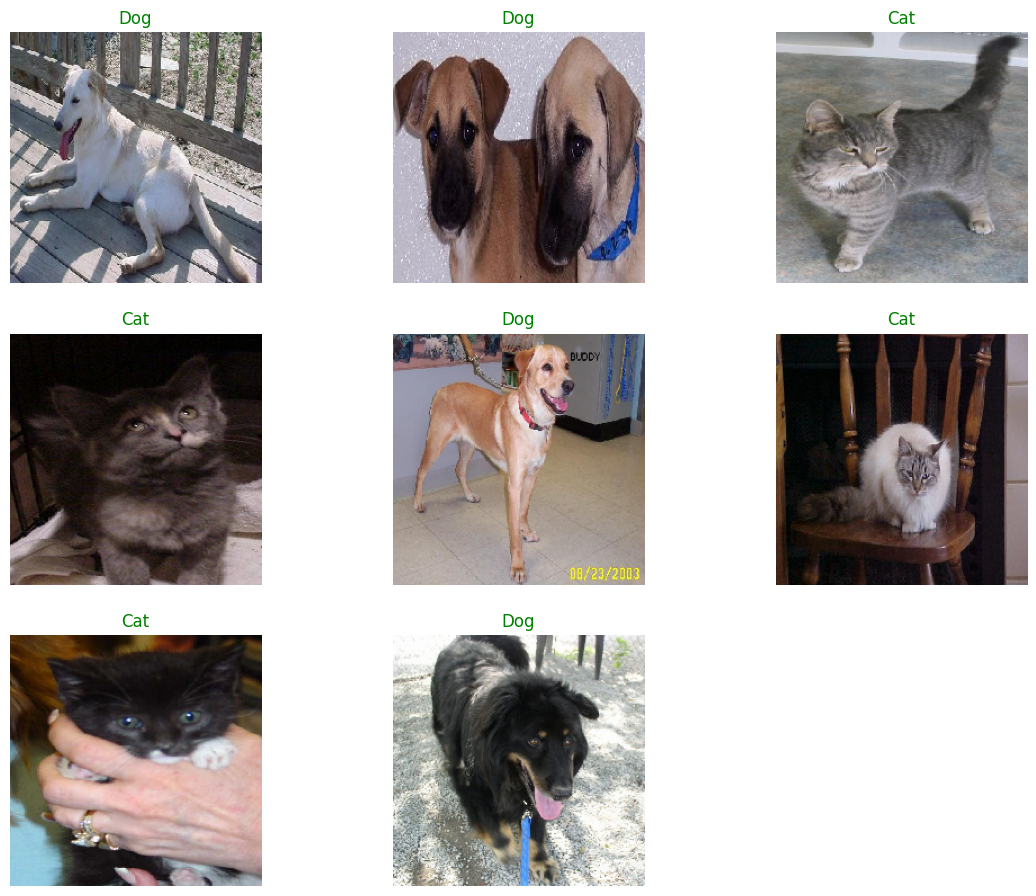

In [16]:
plot_prediction(validation_generator, 9)

In [17]:
# View training process
results = pd.DataFrame(history.history)
results.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.936439,0.543614,0.9676,0.506141,0.0001
1,0.954574,0.397974,0.9792,0.350593,0.0001
2,0.962219,0.277928,0.9828,0.287453,0.0001
3,0.967597,0.217239,0.9892,0.170023,0.0001
4,0.968797,0.170655,0.9852,0.210471,0.0001


In [18]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="plotly_dark",color_discrete_sequence=['#F67280','#DD2706'])
fig.update_layout(   
    title_font_color="#41BEE9", 
    xaxis=dict(color="#41BEE9",title='Epochs'), 
    yaxis=dict(color="#41BEE9")
 )
fig.show()

In [19]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="plotly_dark",color_discrete_sequence=['#F67280','#DD2706'])
fig.update_layout(   
    title_font_color="#41BEE9", 
    xaxis=dict(color="#41BEE9",title='Epochs'), 
    yaxis=dict(color="#41BEE9")
 )
fig.show()